<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Машинное обучение и майнинг данных"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: преподаватель Факультета Компьютерных Наук НИУ ВШЭ Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# Занятие 9. Машинное обучение с Apache Spark
## Часть 2. Пример использования Apache MLLib

In [1]:
%pylab inline
import numpy as np
import pandas as pd
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithSGD

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

In [2]:
def parsePoints(df):
    data = list()
    for i in xrange(len(df)):
        survived = float(df["Survived"][i])
        age = float(df["Age"][i])
        pClass = float(df["Pclass"][i])
        nameL = float(len(df["Name"][i]))
        sex = 1.0 if df["Sex"][i] == "male" else 0.0
        sibSp = float(df["SibSp"][i])
        parch = float(df["Parch"][i])
        fare = float(df["Fare"][i])
        features = [age, pClass, nameL, sex, sibSp, parch, fare]
        
        # for simplicity just skip nans
        if np.isnan(features).sum():
            continue

        p = LabeledPoint(survived, features)
        data.append(p)
    return data

df = pd.read_csv("../../data/titanic_train.csv")
data = parsePoints(df)

print("Number of samples:", len(data))

train, test = sc.parallelize(data).randomSplit([0.7, 0.3], seed=2l)

print("Train positives:", train.filter(lambda p: p.label == 1.0).count())
print("Train negatives:", train.filter(lambda p: p.label == 0.0).count())
print("Test positives:", test.filter(lambda p: p.label == 1.0).count())
print("Test negatives:", test.filter(lambda p: p.label == 0.0).count())

('Number of samples:', 714)
('Train positives:', 201)
('Train negatives:', 291)
('Test positives:', 89)
('Test negatives:', 133)


### Логистическая регрессия

In [3]:
logistic_model = LogisticRegressionWithSGD.train(train, iterations=250)
logistic_model

(weights=[-1.09819878395,-3.0508062163,0.523233326403,-2.57743232273,-1.73622575148,-1.19341948047,0.108247255142], intercept=0.0)

In [4]:
validation = test.map(
    lambda p: (int(round(p.label)), logistic_model.predict(p.features))
    ).cache()

validation.take(10)

[(0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, 0)]

In [5]:
total = float(validation.count())
tp = validation.filter(lambda (real, pred): real == 1 and pred == 1).count() / total
fp = validation.filter(lambda (real, pred): real == 0 and pred == 1).count() / total
tn = validation.filter(lambda (real, pred): real == 0 and pred == 0).count() / total
fn = validation.filter(lambda (real, pred): real == 1 and pred == 0).count() / total

print("True positive rate: %.2f" % tp)
print("Frue positive rate: %.2f" % fp)
print("True negative rate: %.2f" % tn)
print("False negative rate: %.2f" % fn)

True positive rate: 0.07
Frue positive rate: 0.01
True negative rate: 0.59
False negative rate: 0.33


In [6]:
def logistic(w):
    from math import exp
    def predict(x):
        z = w.dot(x)
        return 1. / (1 + exp(-z))
    return predict

predict_proba = logistic(logistic_model.weights)
predicted_proba = test.map(
    lambda p: (p.label, predict_proba(p.features))
).collect()

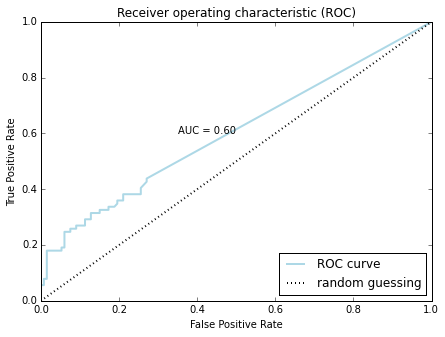

In [7]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve([ r for r, p in predicted_proba ], [ p for r, p in predicted_proba ])
roc_auc = auc(fpr, tpr)

# Plot ROC curve

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)

plt.plot(fpr, tpr, color='lightblue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='dotted', label='random guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
ax.annotate('AUC = %0.2f' %roc_auc, xy=(0.35, 0.6))
plt.show()

### Градиентный бустинг

In [8]:
from pyspark.mllib.tree import GradientBoostedTrees

GBTModel = GradientBoostedTrees.trainRegressor(train, dict(), 
                                               numIterations=20, maxDepth=3)
print(GBTModel)
testGBT = [(p.label, GBTModel.predict(p.features)) for p in test.collect()]

TreeEnsembleModel regressor with 20 trees



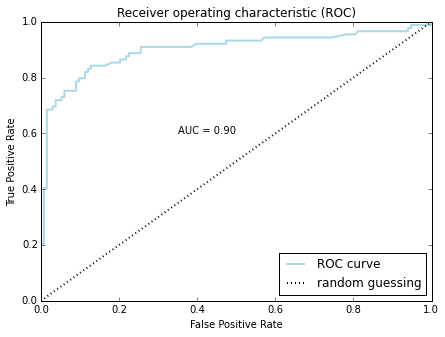

In [9]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve([ r for r, p in testGBT ], [ p for r, p in testGBT ])
roc_auc = auc(fpr, tpr)

# Plot ROC curve

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)

plt.plot(fpr, tpr, color='lightblue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='dotted', label='random guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
ax.annotate('AUC = %0.2f' %roc_auc, xy=(0.35, 0.6))
plt.show()